# Introduction

* To solve classfication problems we are going to consider image classfication as a running example and solving it using Perceptron() model.

# Imports

First Step:

* import all necessary packages, For classification problems, we need to import classes and utilities from sklearn.linear_model
  * This module has implementations for different classification models like Perceptron, LogisticRegression, svm and knn.

We also need to import a bunch f model selection utilities from sklearn.model_selection module and metrics from sklearn.metrics module.

The data preprocessing utilities are imported from sklearn.preprocessing modules.

In [1]:
#common
import numpy as np
import os
import io
import warnings

#sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV

#for pretty printing
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# Handwritten Digit Classification

* We are going to use perceptron classifier to classify given digit images. Since a single perceptron could only be used for binary classfification, we consider only two classes in first half. Eventualy we extend it to multiclass setting.

* Suppose we want to recognize whether the given image is of digit zero or not (digits other than zero). Then the problem could be cast as a binary classification problem.

* The first step is to create a dataset that contains a collection of digit images written by humans. Then each image should be labelled properly.

* Fortunately, we have a standard benchmark dataset called MNIST, well, why not make use of it? Let's import data first...

# Data Loading and Splitting

In [2]:
X,y = fetch_openml('mnist_784', version=1,return_X_y=True)

# it returns Data and label as a pandas dataframe

The data matrix X and the respective label vector y need to be converted to the numpy array by calling a to_numpy method.

In [3]:
X = X.to_numpy()
y = y.to_numpy()

* Let's get some information like number of features, number of classes about the dataset.
* Observe that the labels are of string data type not integers.

In [4]:
target_names = np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0],X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum: {0}, Maximum: {1}'.format(np.min(X),np.max(X)))
print('Number of classes: {0}, type:{1}'.format(len(target_names),y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type:float64
Number of features: 784
Minimum: 0.0, Maximum: 255.0
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


* The MNIST dataset is clean and the range of values that each feature can take is also known. Therefore, the samples in the dataset may not require many data preprocessing techniques.

* However, it is often better to scale many data preprocessing techiques.

* So, we can either use MinMaxScaler or MaxAbsScaler. They don't make any difference as the image pixels can takes only positive values from 0 to 255.

In [5]:
X=MinMaxScaler().fit_transform(X)
print('Minimum: {0}, Maximum: {1}'.format(np.min(X),np.max(X)))

Minimum: 0.0, Maximum: 1.0


# Data Visualization

Let us pick a few images (the images are already shuffled in the dataset) and display them with their respective labels. As said above, the images are stacked as a row vector of size 1 x 784 and therefore must be reshaped to the matrix of size 28 x 28 to display them properly.

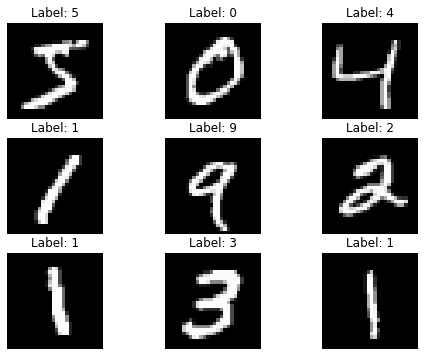

In [6]:
num_images = 9
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
    ax[i,j].set_title('Label: {0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

If you closely observe, you can see that there are moderate variations in the appearance of digits. These matrices are also close to sparse matrix.

# Data Splitting

* Now we know the details such as number of samples, size of each sample, no of features (784), no of classes about the dataset.
* So let us total no of samples into train and test set in the following ratio: 60000/10000
* Since the samples in the data set are already randomly shuffled, we need not to shuffle it again. Therefore using train_test_split() may be skipped.

In [7]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before proceeding further we need to check whether the dataset is balanced or imbalanced. We can do it bpy plotting the distribution of samples in each classes.

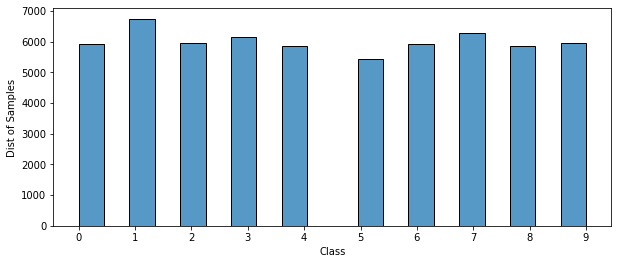

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train), binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.ylabel('Dist of Samples')
plt.show()

# Binary Classification: 0-Detector

## Modifying Labels
* Let us start with a simple classification problem, that is, binary classification.
* Since the original label vector contains 10 classes, we need to modify the number of classes to 2.
Therefore, the label 0 will be changed to 1 and all other labels (1-9) will be changed to -1.
* We name the label vectors as y_train_0 and y_test_0

In [8]:
# initialize new variable name with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train=='0') # remember original labels are of type str not int
# use those indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test=='0')
y_test_0[indx_0]=1

# Baseline Models

Enough about Data!

Let us quickly construct a baseline model with the following rule,

1. Count number of samples per class.
2. The model always outputs the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.

In [9]:
num_pos = len(np.where(y_train_0==1)[0])
num_neg = len(np.where(y_train_0==-11)[0])
print(num_pos, num_neg)

5923 0


In [10]:
base_clf = DummyClassifier(strategy='most_frequent') # there are other strategies

In [11]:
base_clf.fit(x_train, y_train_0)
print('Training accuracy: {0:.2f}'.format(base_clf.score(x_train,y_train_0)))
print('Testing accuracy: {0:.2f}'.format(base_clf.score(x_test,y_test_0)))

Training accuracy: 0.90
Testing accuracy: 0.90


* Now the reason is obvious. The model would have predicted 54077 sample correctly just by outputing -1 for all the input samples. Therefore the accuracy will be 54077/60000 = 90.12%.
* This is the reason why 'accuracy' alone is not always a good measure!

# Perceptron model

Before using Perceptron for Binary Classification, it will be helpful to recall the important concepts (equations) covered in technique course.

# Parameters of Perceptron class

* Let's quickly take a look into the important parameters of the Perceptron()

class sklearn.linear_model.Perceptron(*,penalty=None,alpha=0.0001,l1_ratio=0.15,fit_intercept=True,max_iter=1000,tol=0.001,shuffle=True,verbose=0,eta0=1.0,n_jobs=None,randm_state=0,early_stopping=False,validation_fraction=0.1,n_iter_no_change=5,class_weight=None,warm_start=False)

# Instantiation

* Create an instance of binary classifier (bin_clf) and call fit method to train the model.

In [12]:
bin_clf = Perceptron(max_iter=100, random_state=1729)

#Training and Prediction

* Call the fit method to train the model.
* It would be nice to plot the iteration vs loss curve for the training. However, sklearn does not have a direct function to plot it.
* Nevertheless, we can workaround this using partial_fit method (which will be demonstrated at the end of the lecture)

In [15]:
bin_clf.fit(x_train,y_train_0)

Perceptron(max_iter=100, random_state=1729)

In [17]:
print('Dimension of Weights w: {}'.format(bin_clf.coef_.shape))
print('Bias: {}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimension of Weights w: (1, 784)
Bias: [-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x7f5ecfdc3650>


Let us make predictions on the train set and then calculate the training accuracy.

In [19]:
y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy: ', bin_clf.score(x_train, y_train_0))

Training Accuracy:  0.99095


Let us make predictions on the test set and then calculate the training accuracy.

In [20]:
print('Test Accuracy: ', bin_clf.score(x_test, y_test_0))

Test Accuracy:  0.989


# Displaying predictions

* Take few images from the testset at random and display it with the corresponding predictions.
* Plot a few images in a single figure window along with their respective predictions.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


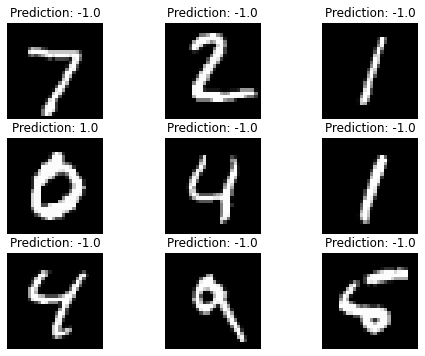

In [23]:
y_hat_test_0 = bin_clf.predict(x_test)
num_images = 9
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Prediction: {0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

It seems that there are a significant number of images that are correctly classified. Let's see how many?

In [25]:
indx_0 = np.where(y_test_0==1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


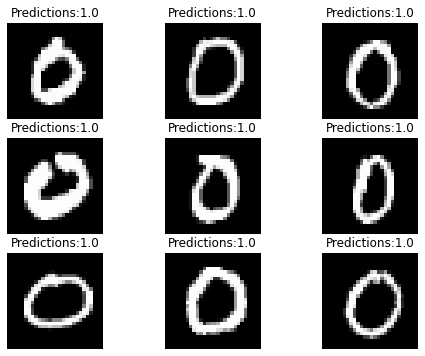

In [27]:
zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Predictions:{}'.format(str(zeroLabls[index+j])))
    ax[i,j].set_axis_off()

In [30]:
num_misclassified = np.count_nonzero(zeroLabls==-1)
num_correctpred = len(zeroLabls)-num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9193877551020408


* This above score is less than the accuracy score of the model but it seems preety descent!
* Will it be the same if we consider an other digit, say, 5 for positive class and all other class as negative?.. Of course not. You may cross check it.

# Better Evaluation metrics

* We now know that using the accuracy alone to measure the performance of the model is not suitable (especially for imbalanced datasets), so which are the more suitable metrics then?

#Confusion Matrix

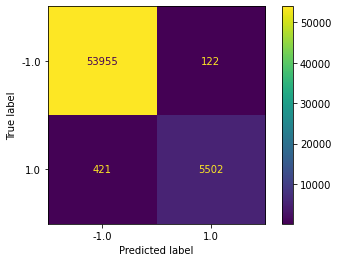

In [31]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

* Pay attention to the number of FPs and FNs. Suppose for some reasons, we want the classifier to avoid FPs to a good extent of FNs, how can we achieve it?
* To answer it, let's compute the other metrics which take FPs and FNs into account.

# Precision and Recall

* We an use the function classification_report to compute these parameters. However, for the time being let's compute these parameters using the data from the confusion matrix manually (not a difficult thing to do, right?)

In [34]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [35]:
precision = tp/(tp+fp)
print('Precisions: ', precision)
recall = tp/(tp+fn)
print('Recall: ', recall)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy: ', accuracy)

Precisions:  0.9783072546230441
Recall:  0.9289211548201924
Accuracy:  0.99095


* The precision is close to 0.98. Despite it, we still want to increase the precision. Let's come back to this later.
* In general, we would like to know whether the model under consideration with the set hyper-parameters is a good one for a given problem.

# Cross Validation

* Well to address this, we have to use cross-validation folds and measure the same metrics across these folds for different values of hyper-parameters.
* However perceptron does not have many hyperparameters other than the learning rate.
* For the moment, we set the learning rate to its default value. Later we use GridSearchCV to find the better value for the learning rate.

In [36]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, x_train, y_train_0, cv=5,
                          scoring=['precision','recall','f1'],
                          return_estimator=True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.64008641, 2.64727688, 1.77891469, 1.53330541, 1.96839714]),
 'score_time': array([0.04620457, 0.08314633, 0.04392338, 0.04281497, 0.04310036]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


Note
* The perceptron estimator passed as an arguement to the function cross_validate is internally cloned num_fold (cv=5) times and fitted independently on each fold. (you can check this by setting warm_start=True)
* Compute the average and standard deviation of scores for all three metrics on k=5 folds to measure the generalization.

In [37]:
print('f1,        avg:{0:.2f}, std:{1:.3f}'.format(scores['test_f1'].mean(),scores['test_f1'].std()))
print('precision, avg:{0:.2f}, std:{1:.2f}'.format(scores['test_precision'].mean(),scores['test_precision'].std()))
print('recall,    avg:{0:.2f}, std:{1:.2f}'.format(scores['test_recall'].mean(),scores['test_recall'].std()))

f1,        avg:0.94, std:0.013
precision, avg:0.96, std:0.01
recall,    avg:0.92, std:0.03


* Let us pick the first estimator returned by the cross_validate function.
* So we can hope that the model might also perform well on the test data. Let's check that out.

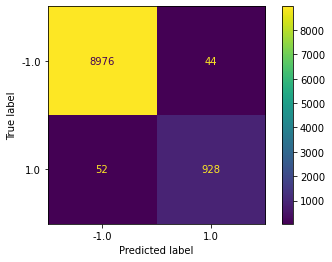

In [41]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_test_0,values_format='.5g')

In [42]:
print('Precision %.2f'%precision_score(y_test_0,y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0,y_hat_test_0))

Precision 0.95
Recall 0.95


This is good!

# Way-2 for Generalization:
(Optional)

* There is another approach of getting predicted labels via cross-validation and using it to measure the generalization.
* In this case, each sample in the dataset will be part of only one test set in the splitted folds.

In [43]:
y_hat_train_0 = cross_val_predict(bin_clf, x_train, y_train_0, cv=5)

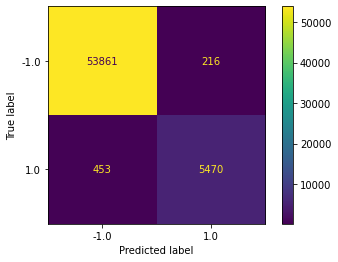

In [44]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [46]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [48]:
precision = tp/(tp+fp)
print('Precisions: ', precision)
recall = tp/(tp+fn)
print('Recall: ', recall)
f1 = 2/((1/precision)+(1/recall))
print('f1',f1)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy: ', accuracy)

Precisions:  0.9620119591980303
Recall:  0.9235184872530812
f1 0.9423722973555
Accuracy:  0.98885


* Compare the precision and recall score obtained by the above method with that of the previous method
* Finally, we can print all these scores as a report using the classification_report function

In [49]:
print('Precision %.2f'%precision_score(y_test_0,y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0,y_hat_test_0))
print('-'*50)
print(classification_report(y_train_0,y_hat_train_0))

Precision 0.95
Recall 0.95
--------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



# Precision/Recall Tradeoff

* Often time we need to make a trade off between precision and recall scores of a model.
* It depends on the problem at hand.
* It is important to note that should not pass the predicted labels as input to precision_recall_curve function, instead we need to pass the probability scores or the output from the decision function!
* The Perceptron() class contains a decision_function method, therefore we can make use of it.
* Then, internally the decision scores are sorted, tps and fps will be computed by changing the threshold from index[0] to index[-1].
* Let us compute the scores from the decision function.

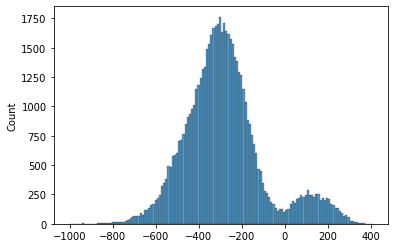

In [50]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(x_train, y_train_0)
y_scores = bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

Can you think why there are so many negative values than the positives?

Hint: Class-Imbalance

* Suppose threshold takes the value of -600, then all the samples having score greater than -600 is set to 1(+ve label) and less than it is set to -1(neg label).
* Therefore, the number of False Positives will be increased. This wll in turn reduce the precision score to a greater extent.
* On the otherhand, if the threshold takes the value of, say 400. Then, the number of false negatives will be increase ad hence the recall will reduce to a greater extent.
* Let's see it in action.

In [54]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)

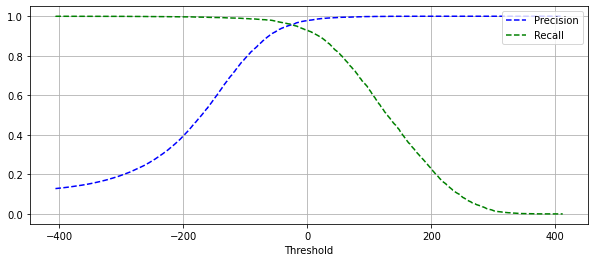

In [56]:
plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions[:-1],'b--',label='Precision')
plt.plot(thresholds, recalls[:-1],'g--',label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [57]:
# get the index of threshold around zero
idx_th = np.where(np.logical_and(thresholds>0,thresholds<1))
print('precision for zero threshold: ', precision[idx_th[0][0]])

precision for zero threshold:  0.9783072546230441


* Here is the solution: to the question how can we increase the precision of the classifier by compromising the recall, we can make use of the above plot.
* Let's see how

# The ROC Curve

In [58]:
from sklearn.metrics import roc_curve

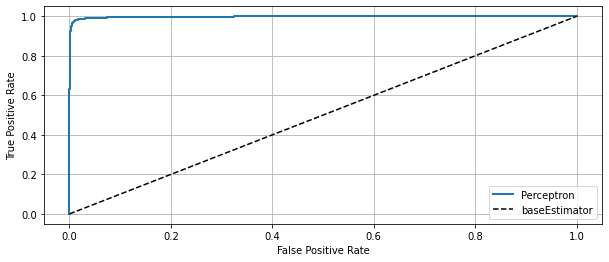

In [59]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr,tpr,linewidth=2,label='Perceptron')
plt.plot([0,1], [0,1], 'k--', label='baseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

# Warm Start vs Cold Start

## Cold Start

* If we execute the fit method of bin_clf repeatedely, we get the same score for both training and testing accuracy.
* This because every time the fit method is called, the model weights are initialized to the same values. Therefore, we obtain the same score.
* This is termed as cold start. Let's execute the following cell 4 times and observe the score.

In [60]:
bin_clf.fit(x_train, y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy: ', bin_clf.score(x_train,y_train_0))
print('Test Accuracy: ', bin_clf.score(x_test,y_test_0))

Training Accuracy:  0.99095
Test Accuracy:  0.989


## Warm Start

* As you might have guessed, there is an approach called Warm Start
* Setting warm_start=True retains the weight values of the model after max_iter and hence produce different results for each execution.
* Warm setting is useful in many ways. It helps us train the model by initializing the weight values from the previous state. So we can pause the training and resume it whenever we get the resource for computation.
* Of course, it is not required for simple models like perceptron and for a small dataset like MNIST
* In this notebook, we use this feature to plot the iteration vs loss curve.
* Let us execute the following lines of code 4 times and observe how the training accuracy changes for each execution.

In [61]:
bin_clf_warm = Perceptron(max_iter=100, random_state=1729, warm_start=True)

In [62]:
bin_clf_warm.fit(x_train, y_train_0)
print('Training Accuracy:', bin_clf_warm.score(x_train,y_train_0))

Training Accuracy: 0.99095
